In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [63]:
main_df = pd.read_csv('../data/World Energy Consumption.csv')
main_df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [64]:
countries = ['New Zealand']
filtered_df = main_df[main_df['country'].isin(countries)]
filtered_df

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
13298,New Zealand,1900,NZL,809099.0,5.528757e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13299,New Zealand,1901,NZL,828174.0,5.546344e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13300,New Zealand,1902,NZL,848778.0,5.970456e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13301,New Zealand,1903,NZL,870968.0,6.532845e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13302,New Zealand,1904,NZL,893740.0,6.505505e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13416,New Zealand,2018,NZL,4838528.0,1.710136e+11,30.096,0.008,6.973,0.034,88.870,...,0.230,0.103,-1.104,-0.094,5.471,423.683,2.05,1130.772,4.720,2.117
13417,New Zealand,2019,NZL,4959033.0,NaN,40.398,0.014,9.552,0.047,96.793,...,0.297,0.128,9.077,0.475,5.946,449.684,2.23,1198.999,5.090,2.251
13418,New Zealand,2020,NZL,5061130.0,NaN,80.401,0.038,16.884,0.085,92.865,...,0.370,0.176,2.199,0.108,6.054,450.492,2.28,1196.234,5.279,2.525
13419,New Zealand,2021,NZL,5129730.0,NaN,-21.972,-0.019,12.998,0.067,91.623,...,0.461,0.231,14.638,0.861,6.915,510.748,2.62,1348.051,6.034,2.937


In [65]:
columns_needed = ['country', 'year', 'greenhouse_gas_emissions']
data_selected = filtered_df[columns_needed]

# Check for missing values in the selected columns
data_selected.isnull().sum()

country                       0
year                          0
greenhouse_gas_emissions    100
dtype: int64

In [66]:
# Drop rows with missing values
data_selected = data_selected.dropna()
data_selected.isnull().sum()

country                     0
year                        0
greenhouse_gas_emissions    0
dtype: int64

In [67]:
# Carban emissions forcasting
def forecast_carban_emissions(country, years_to_forecast=8):
    country_data = data_selected[data_selected['country'] == country]
    country_data = country_data.set_index('year')
    series = country_data['greenhouse_gas_emissions'].dropna()

    if series.empty:
        print(f"No data available for {country} to forecast carbon emissions.")
        return None
    
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=years_to_forecast)

    forecasting_years_range = np.arange(country_data.index[-1] + 1, country_data.index[-1] + years_to_forecast + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series.values, label='Actual Data')
    plt.plot(forecasting_years_range, forecast.values, label='Forecast', color='red')
    plt.title(f'{country} Carbon Emissions Forecast')
    plt.xlabel('Year')
    plt.ylabel('Carbon Emissions (MtCO2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\WINDOWS\AppData\Local\Programs\Pytho

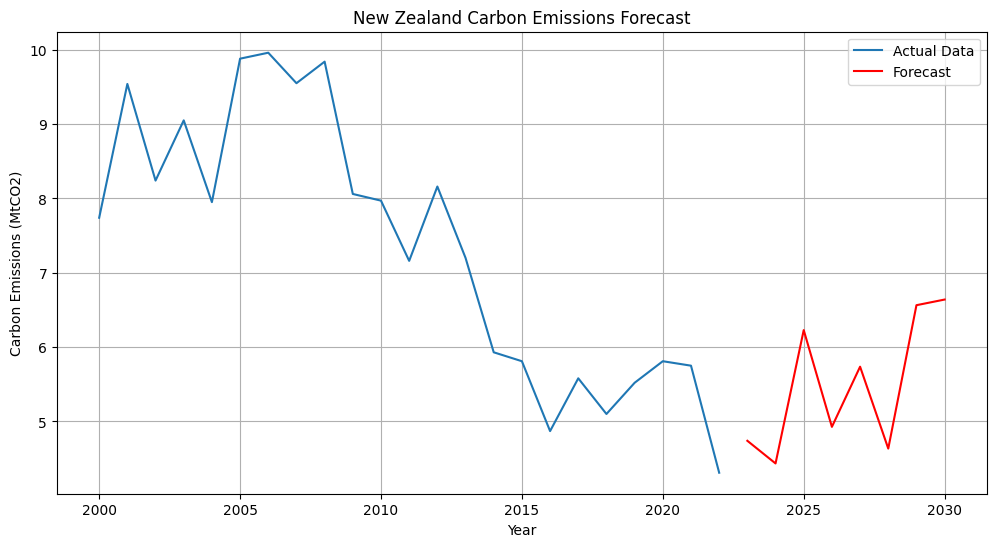

In [68]:
for country in countries:
    forecast_carban_emissions(country, years_to_forecast=8)

In [69]:



def test_model_accuracy(country, test_size=5):
    country_data = data_selected[data_selected['country'] == country]
    country_data = country_data.set_index('year')
    series = country_data['greenhouse_gas_emissions'].dropna()

    if len(series) <= test_size:
        print(f"Not enough data to evaluate model for {country}.")
        return

    train, test = series[:-test_size], series[-test_size:]

    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    forecast = model_fit.forecast(steps=test_size)

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    print(f"Accuracy for {country}:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"MAPE: {rmse:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, forecast.values, label='Forecast', color='red')
    plt.title(f'{country} Forecast vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Carbon Emissions (MtCO2)')
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\WINDOWS\AppData\Local\Programs\Pyth

Accuracy for New Zealand:
MAE: 1.38
MSE: 2.46
MAPE: 1.57%


c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


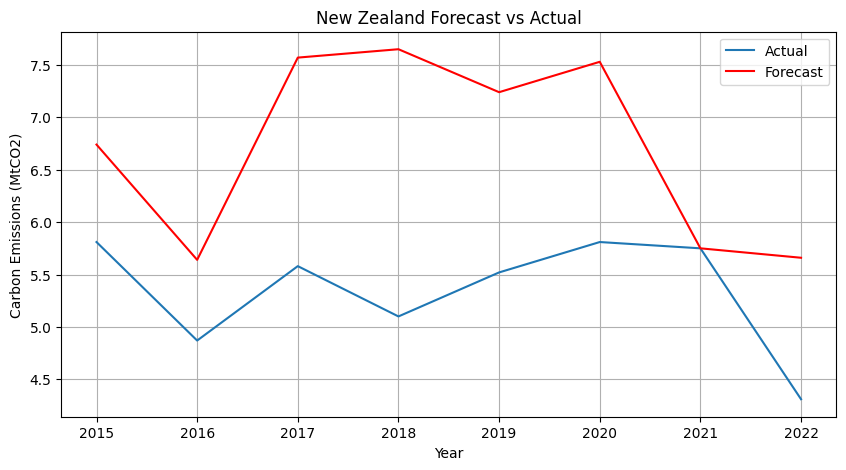

In [70]:
for country in countries:
    test_model_accuracy(country, test_size=8)